# 1. Domain Appropriate Question: What is the likelihood of success for a listing with respect to its features ?

## 1.1. Getting data specific to the question from the database & saving in a CSV that can be re-utilized

NOTE: Some feature have been reasonably elimited in the query

(Refer Report -> for reasons behind those eliminations)

In [15]:
!pip install pymysql
!pip install cryptography
!pip install PyMySQL[rsa]
!pip install mysql-connector-python
!pip install pandas
!pip install -U scikit-learn scipy matplotlib
!pip install tensorflow
!pip install statsmodels
!pip install seaborn


import pandas as pd
import mysql.connector

# host = 'marmoset03.shoshin.uwaterloo.ca'
# port = 3307
# user = '<username>'
# password = '<password>'
# database = 'Group13'

# conn = mysql.connector.connect(
#     host = host, user = user, password = password, database = database
# )

# query = """ With AvailabilitiesCount AS
#                 (
#                     SELECT ListingId, count(listingCalendar_Date) as totalAvailabilities, AVG(listingCalendar_Price) as price, AVG(listingCalendar_AdjustedPrice) as adjustedPrice
#                       FROM ListingCalendar
#                       GROUP BY ListingId
#                 ),
#               ReservationsCount AS
#                 (
#                     SELECT ListingId, count(listingCalendar_Date) as totalReservations
#                       FROM ReservedCalendar
#                       GROUP BY ListingId
#                 ),
#               ListingSuccesRate AS
#                 (
#                     SELECT ListingId, COALESCE(totalReservations / totalAvailabilities, 0) as successRate, price, adjustedPrice
#                       FROM AvailabilitiesCount LEFT OUTER JOIN ReservationsCount
#                             USING (ListingId)
#                 )
#             SELECT
#                   listingInstantBookable,
#                   IfNull(listingMinimumNights, 0) AS listingMinimumNights,
#                   IfNull(listingMaximumNights, 0) AS listingMaximumNights,
#                   price,
#                   adjustedPrice,
#                   propertyType,
#                   roomType,
#                   IfNull(accommodates, 0) AS accommodates,
#                   IfNull(noBathrooms, 0) AS noBathrooms,
#                   bathroomType,
#                   IfNull(noBedrooms, 0) AS noBedrooms, 
#                   IfNull(noBeds, 0) AS noBeds,
#                   propertyNeighbourhood, 
#                   propertyNeighbourhoodCleansed,
#                   ST_X(propertyCoordinates) as coordinateLatitude,
#                   ST_Y(propertyCoordinates) as coordinateLongitude,
#                   successRate
#                 FROM ListingInfo INNER JOIN ListingSuccesRate
#                       USING (ListingId);"""
            
# df = pd.read_sql(query, con = conn)

# df.to_csv('relavantDataset.csv')

df = pd.read_csv('relavantDataset.csv')
df.head()

,Unnamed: 0,listingInstantBookable,listingMinimumNights,listingMaximumNights,price,adjustedPrice,propertyType,roomType,accommodates,noBathrooms,bathroomType,noBedrooms,noBeds,propertyNeighbourhood,propertyNeighbourhoodCleansed,coordinateLatitude,coordinateLongitude,successRate
0,0,0,28,730,469.000000,469.000000,Entire home,Entire home/apt,10,3.0,bath,5,7,"Toronto, Ontario, Canada",Little Portugal,43.64590,-79.42423,1.0000
1,1,1,180,365,104.000000,104.000000,Private room in rental unit,Private room,2,1.5,bath,1,1,"Toronto, Ontario, Canada",Waterfront Communities-The Island,43.64080,-79.37673,0.0000
2,2,0,2,90,186.931507,186.931507,Entire condo,Entire home/apt,2,1.0,bath,1,1,"Vancouver, British Columbia, Canada",West End,49.28201,-123.12669,0.4192
3,3,0,30,180,150.000000,150.000000,Entire rental unit,Entire home/apt,2,1.0,bath,1,1,"Vancouver, British Columbia, Canada",Kensington-Cedar Cottage,49.25622,-123.06607,0.5836
4,4,1,3,7,151.465753,151.465753,Entire home,Entire home/apt,4,1.0,bath,1,2,"Vancouver, British Columbia, Canada",Kensington-Cedar Cottage,49.24922,-123.08139,1.0000


# 3. Pre-processing of Data

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

df = df.drop(df.columns[0], axis=1)

roomTypeMap = {
    'Shared room' : 1, 
    'Private room' : 2,
    'Hotel room' : 3,
    'Entire home/apt' : 4
}

bathroomTypeMap = {
    'private bath': 1,
    'shared bath': 2,
    'half bath': 3,
    'bath': 4,
    'shared half bath': 5,
    'private half bath': 6
}

print(df['bathroomType'].unique())

df['roomType'] = df['roomType'].map(roomTypeMap)

df['bathroomType'] = df['bathroomType'].map(bathroomTypeMap)
df['bathroomType'] = df['bathroomType'].fillna(0)

le = LabelEncoder()
df['propertyType'] = le.fit_transform(df['propertyType'])   # df['propertyType'].astype('category').cat.codes

df['propertyNeighbourhood'] = le.fit_transform(df['propertyNeighbourhood'])
df['propertyNeighbourhoodCleansed'] = le.fit_transform(df['propertyNeighbourhoodCleansed'])

df.head()

['bath' 'private bath' 'shared bath' 'half bath' nan 'shared half bath'
 'private half bath']


,listingInstantBookable,listingMinimumNights,listingMaximumNights,price,adjustedPrice,propertyType,roomType,accommodates,noBathrooms,bathroomType,noBedrooms,noBeds,propertyNeighbourhood,propertyNeighbourhoodCleansed,coordinateLatitude,coordinateLongitude,successRate
0,0,28,730,469.000000,469.000000,17,4,10,3.0,4.0,5,7,90,165,43.64590,-79.42423,1.0000
1,1,180,365,104.000000,104.000000,53,2,2,1.5,4.0,1,1,90,310,43.64080,-79.37673,0.0000
2,0,2,90,186.931507,186.931507,13,4,2,1.0,4.0,1,1,94,314,49.28201,-123.12669,0.4192
3,0,30,180,150.000000,150.000000,21,4,2,1.0,4.0,1,1,94,140,49.25622,-123.06607,0.5836
4,1,3,7,151.465753,151.465753,17,4,4,1.0,4.0,1,2,94,140,49.24922,-123.08139,1.0000


## 4. Final Feature Selection

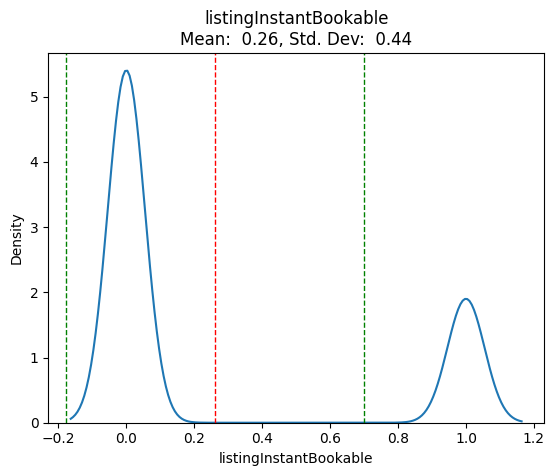

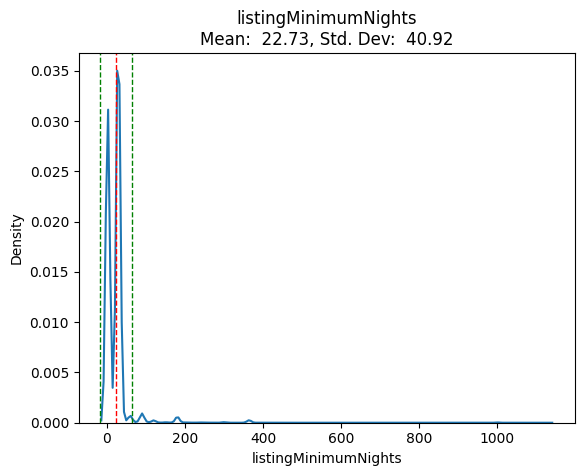

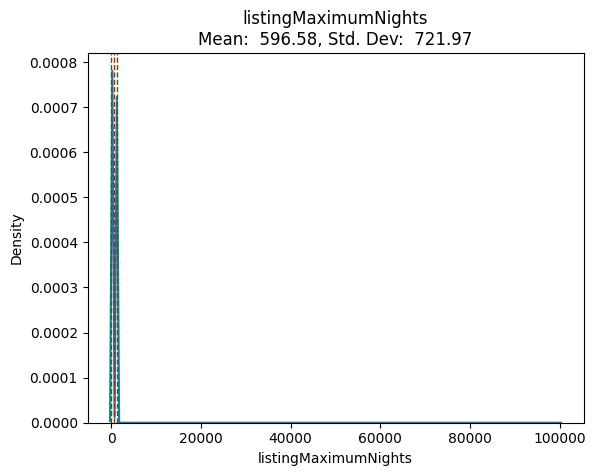

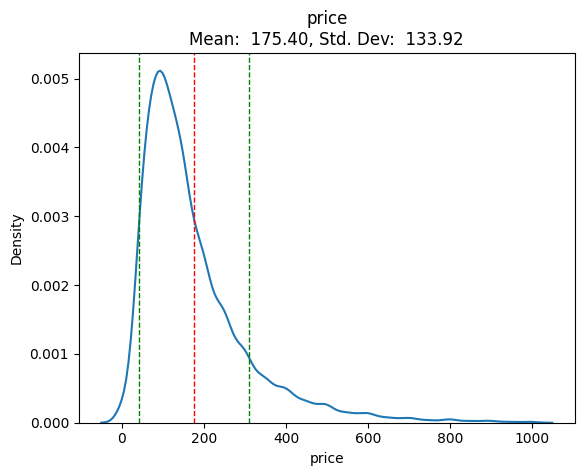

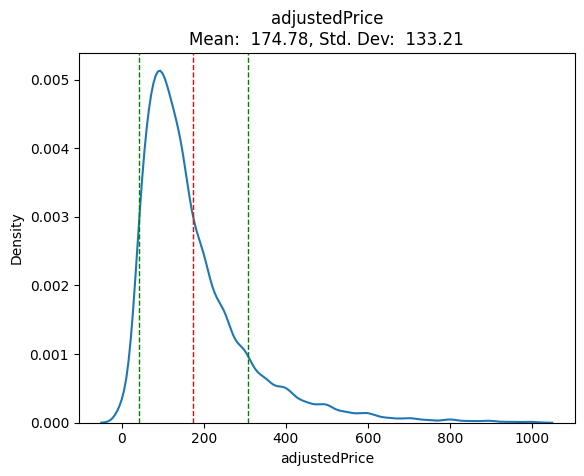

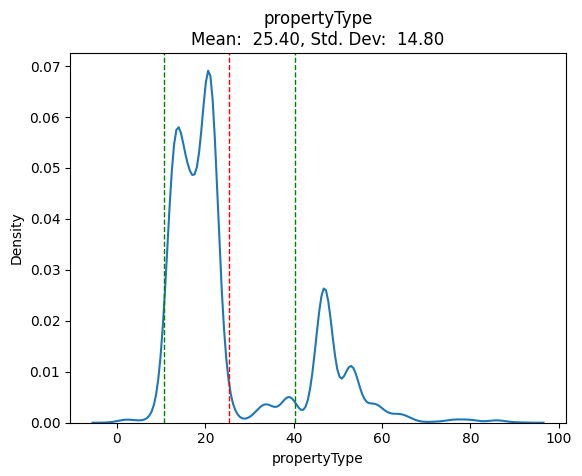

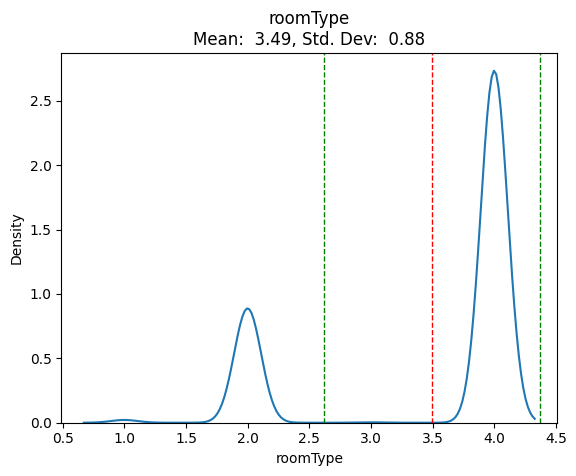

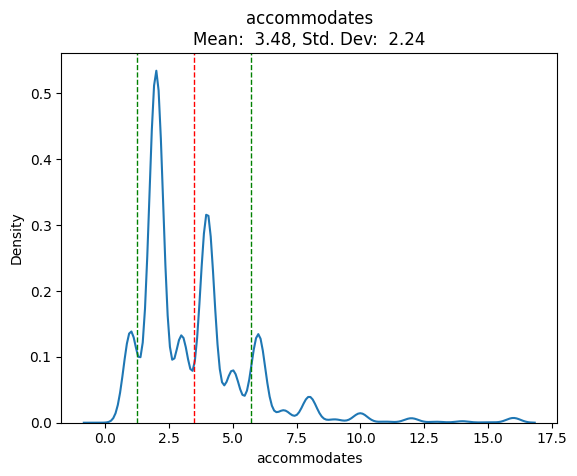

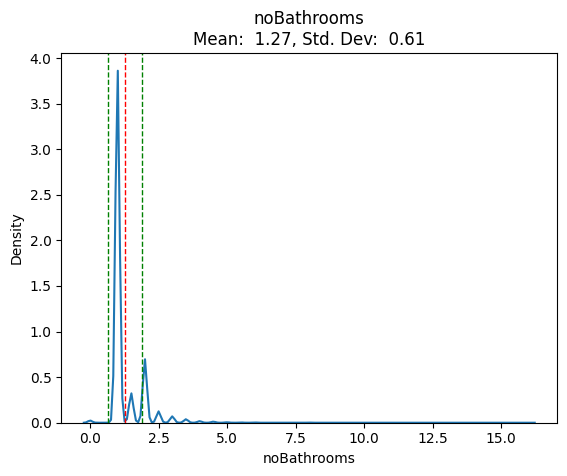

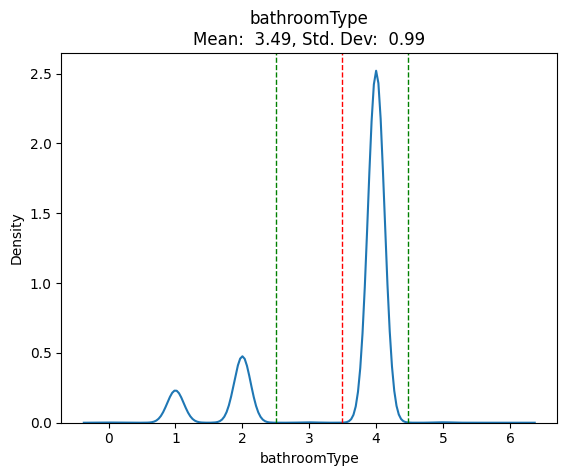

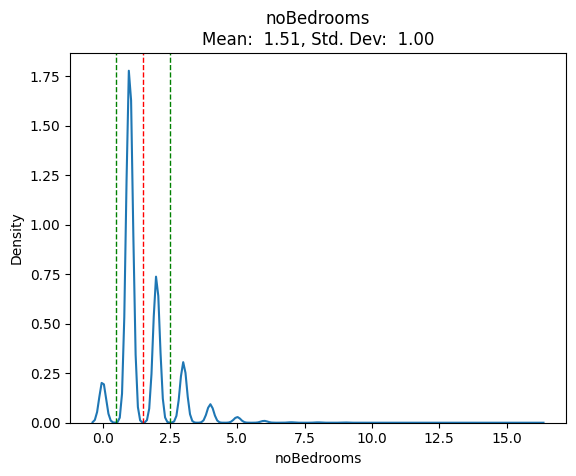

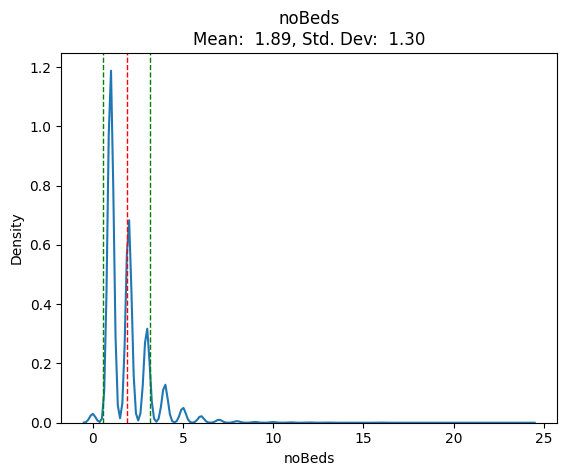

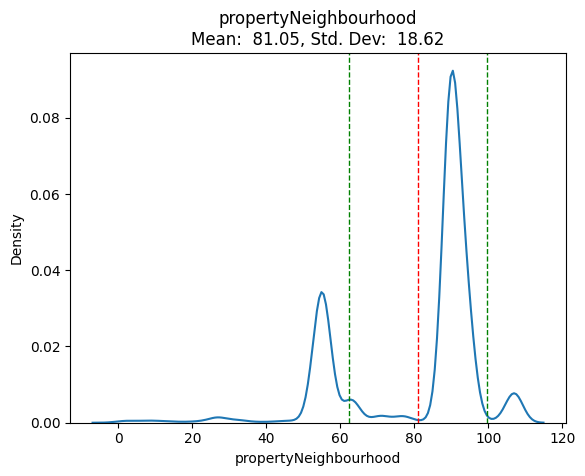

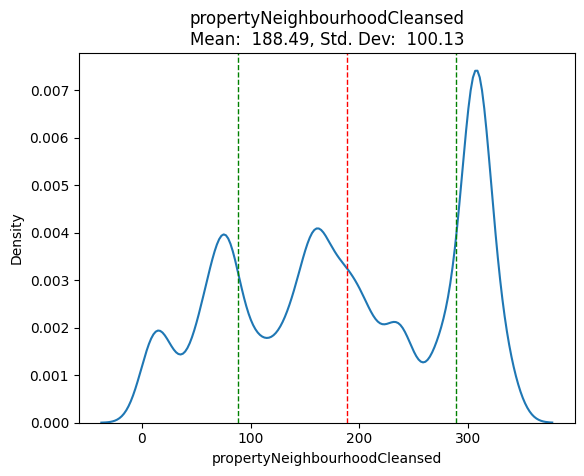

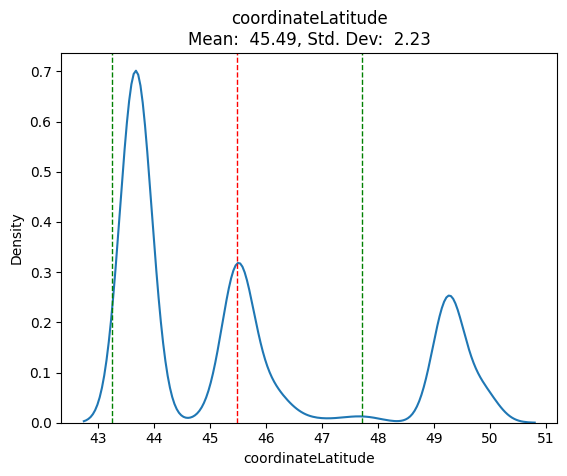

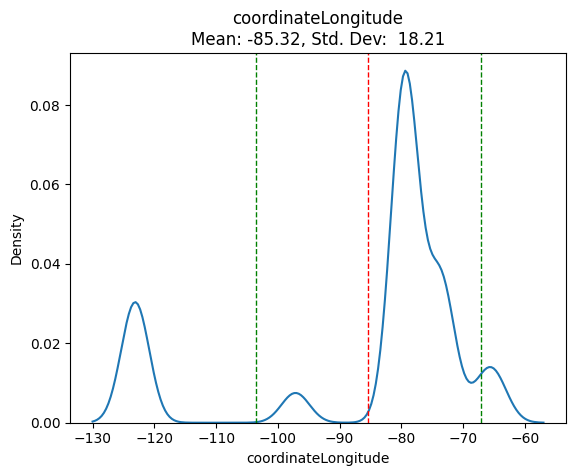

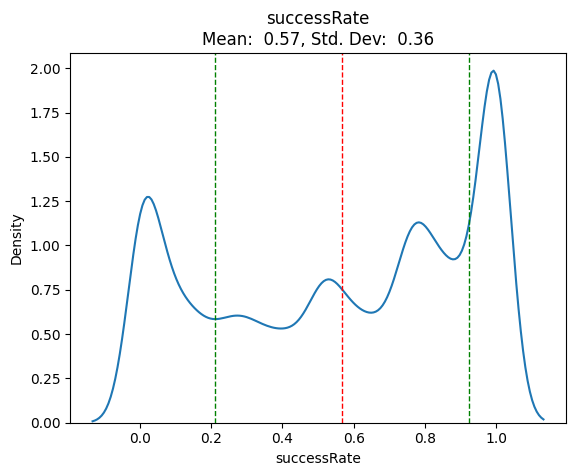

successRate    1.0
Name: successRate, dtype: float64

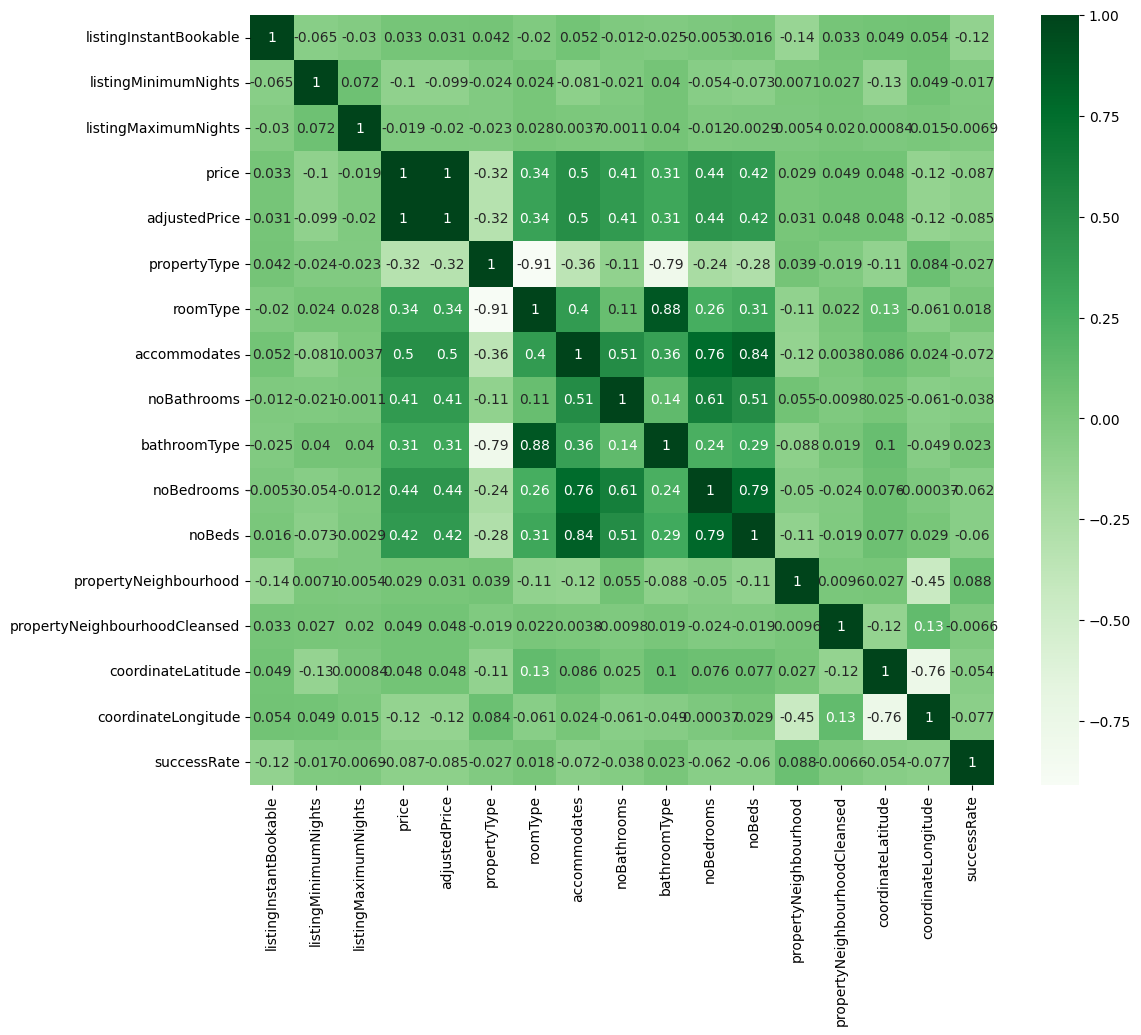

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeClassifier


# Separate out variables
X = df.drop(["successRate"], axis=1)        # Potential Independent Variables
Y= df["successRate"]                        # Dependent Variable


# ----- Technique 1 - Checking distribution of values -----
for column in df.columns:
    if df[column].dtype != 'object':
        data = df[column]
        mean = np.mean(data)
        std_dev = np.std(data)
        
        # counts, bins, patches = plt.hist(data, bins=10, density = True, alpha = 0.5)
        # plt.plot((bins[:-1] + bins[1:]) / 2, counts, '-o')
        sns.kdeplot(data)
        
        plt.axvline(mean, color='red', linestyle='dashed', linewidth=1)
        plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1)
        plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1)
        plt.title(f"{column}\nMean: {mean: .2f}, Std. Dev: {std_dev: .2f}")
        plt.show()

# ----- Technique 2 - Correlation Analysis -----
## Using Pearson Coefficient
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)

## Correlation with output variable
cor_target = abs(cor["successRate"])

## Selecting highly correlated features
relavant_features = cor_target[cor_target > 0.5]
relavant_features


# ----- Technique 3 - PCA (Principal Component Analysis) -----

In [18]:
X = df.drop(["successRate"], axis=1)        # will be avaialable as 'Y'

# Eliminited
X = df.drop(["propertyNeighbourhood"], axis=1)
X = df.drop(["propertyNeighbourhoodCleansed"], axis=1)

X.head()

,listingInstantBookable,listingMinimumNights,listingMaximumNights,price,adjustedPrice,propertyType,roomType,accommodates,noBathrooms,bathroomType,noBedrooms,noBeds,propertyNeighbourhood,coordinateLatitude,coordinateLongitude,successRate
0,0,28,730,469.000000,469.000000,17,4,10,3.0,4.0,5,7,90,43.64590,-79.42423,1.0000
1,1,180,365,104.000000,104.000000,53,2,2,1.5,4.0,1,1,90,43.64080,-79.37673,0.0000
2,0,2,90,186.931507,186.931507,13,4,2,1.0,4.0,1,1,94,49.28201,-123.12669,0.4192
3,0,30,180,150.000000,150.000000,21,4,2,1.0,4.0,1,1,94,49.25622,-123.06607,0.5836
4,1,3,7,151.465753,151.465753,17,4,4,1.0,4.0,1,2,94,49.24922,-123.08139,1.0000


# 5. Model Building using Multi-layer perceptron (MLP)

## 5.1. Switch to GPU (requires support)

In [19]:
# import tensorflow as tf

# config = tf.compat.v1.ConfigProto(device_count = {"GPU": 1})
# session = tf.compat.v1.Session(config = config)
# # print(tf.config.list_physical_devices('GPU'))

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


2023-04-14 01:17:02.797128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 01:17:02.799169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 01:17:02.800415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 01:17:02.806049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-14 01:17:02.806228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not ident

## 5.2. MLP 

In [20]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Split test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# Build Model
no_epochs = 30

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='sigmoid', input_shape=(X_train.shape[1], )),
  tf.keras.layers.Dense(512, activation='sigmoid'),
  tf.keras.layers.Dense(1024, activation='sigmoid'),
  tf.keras.layers.Dense(1024, activation='sigmoid'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
results = model.fit(X_train, Y_train, epochs=no_epochs, verbose=1)

# Split
Y_train_Prediction = model.predict(X_train)
Y_test_Prediction = model.predict(X_test)


# Check Accuracy
train_score = model.evaluate(X_train, Y_train, verbose=0)
test_score = model.evaluate(X_test, Y_test, verbose=0)

print(f"Train MSE {train_score}:")
print(f"Test MSE {test_score}:")


Epoch 1/30
838/838 [==============================] - 18s 20ms/step - loss: 0.2147
Epoch 2/30
838/838 [==============================] - 19s 23ms/step - loss: 0.1047
Epoch 3/30
838/838 [==============================] - 17s 20ms/step - loss: 0.0108
Epoch 4/30
838/838 [==============================] - 16s 19ms/step - loss: 0.0054
Epoch 5/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0051
Epoch 6/30
838/838 [==============================] - 17s 21ms/step - loss: 0.0043
Epoch 7/30
838/838 [==============================] - 15s 17ms/step - loss: 0.0031
Epoch 8/30
838/838 [==============================] - 11s 13ms/step - loss: 0.0032
Epoch 9/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0029
Epoch 10/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0036
Epoch 11/30
838/838 [==============================] - 11s 13ms/step - loss: 0.0038
Epoch 12/30
838/838 [==============================] - 12s 15ms/step - loss: 0.0023
E

# 6. Model Validation

## 6.1. Validation Against Test Set

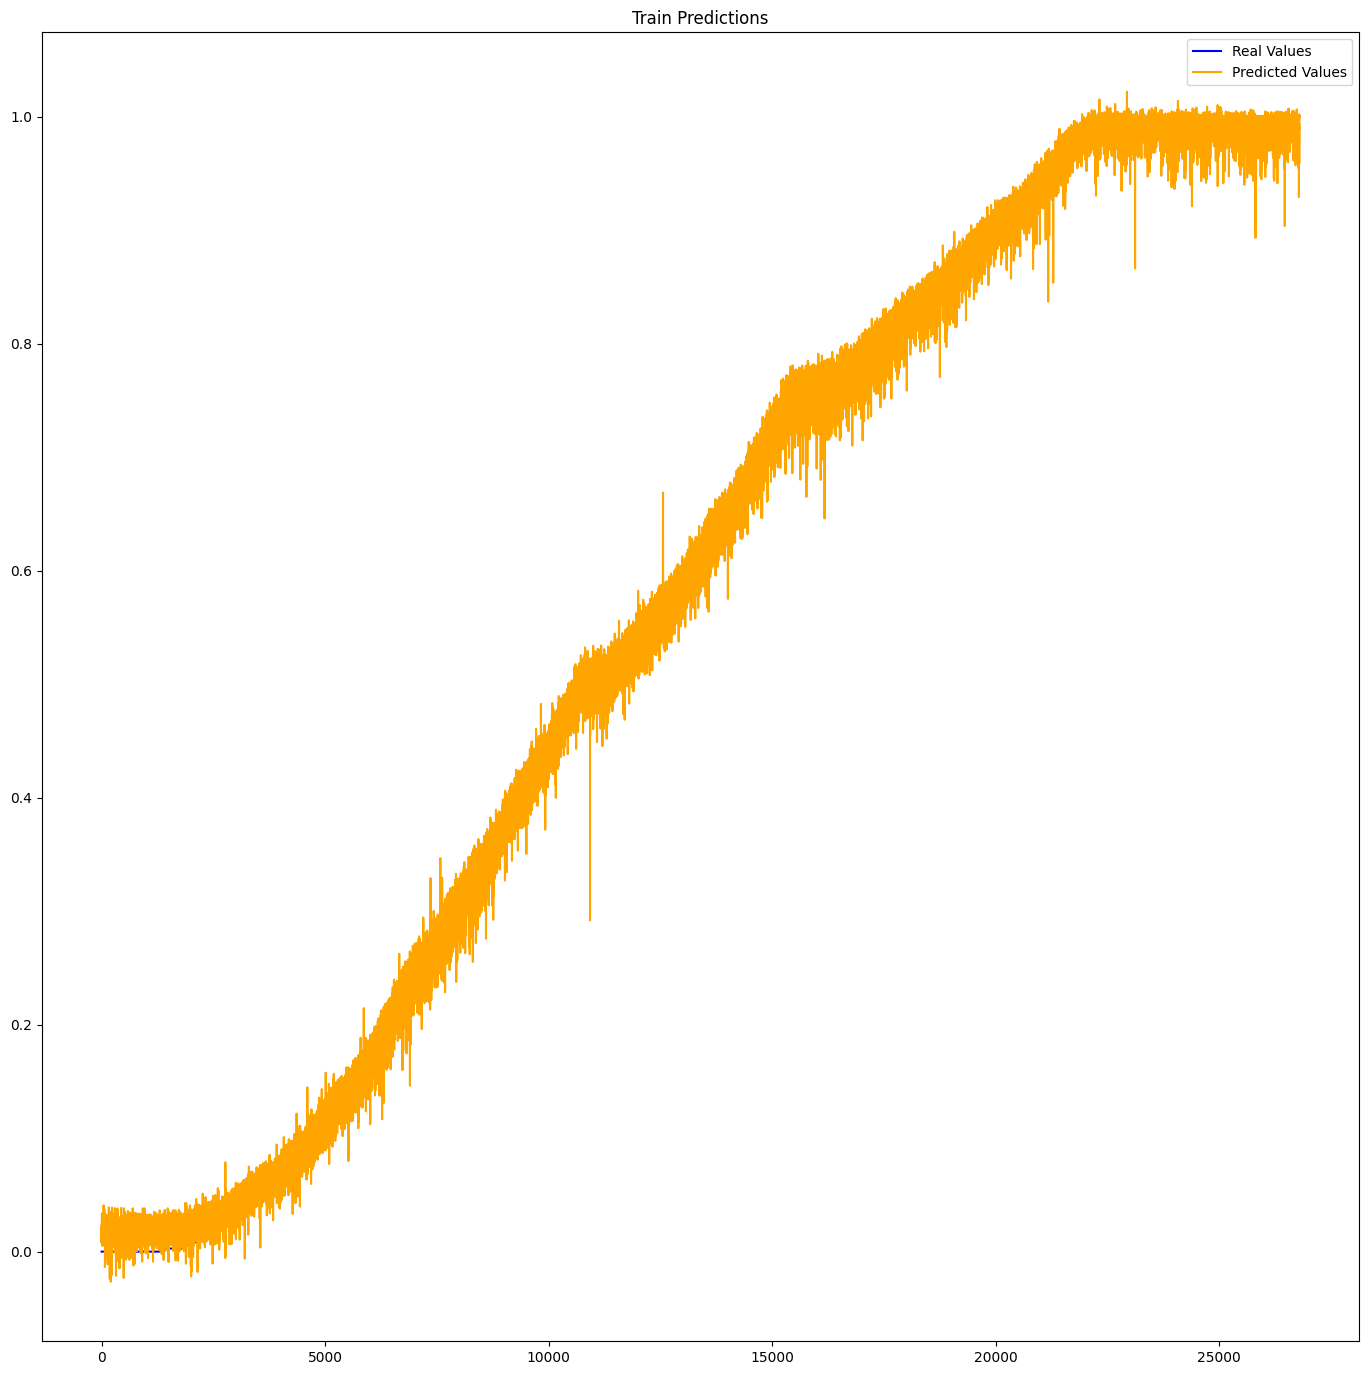

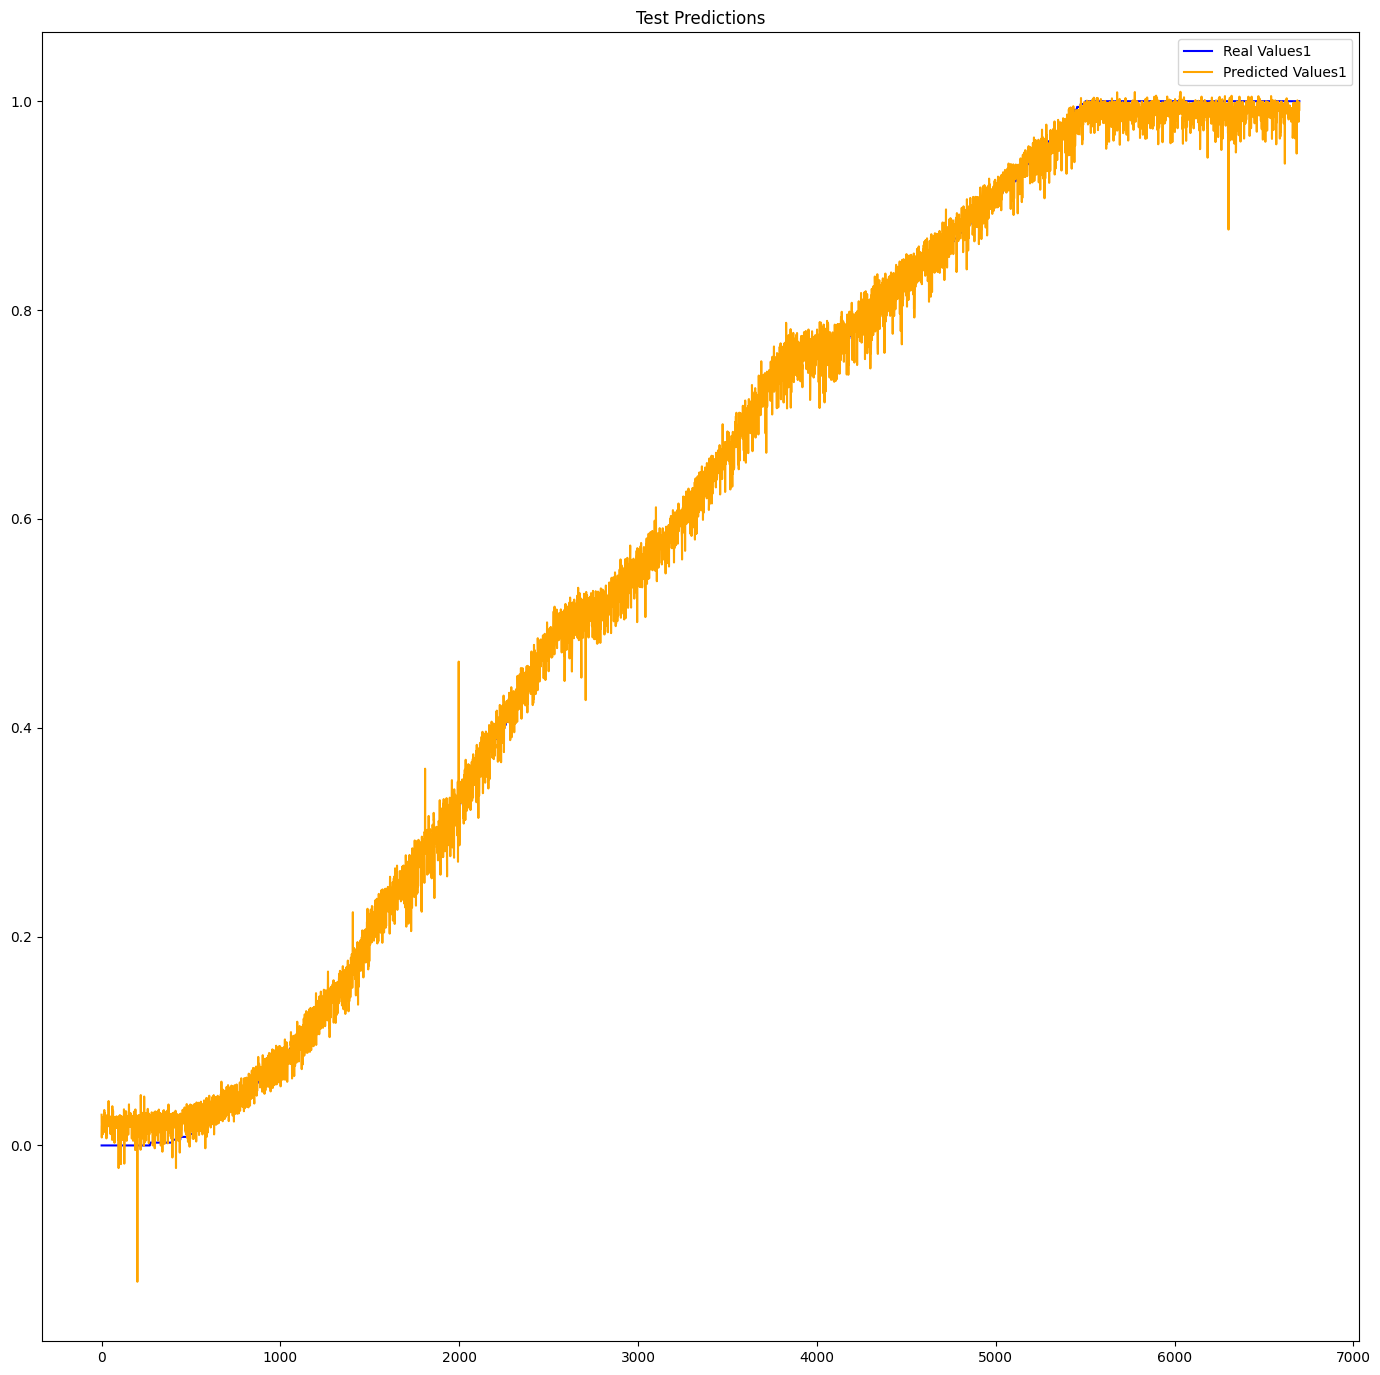

In [21]:
import matplotlib.pyplot as plt

# Reusable graph drawing function
def drawGraphs (Y_train_in, Y_train_Prediction_in, Y_test_in, Y_test_Prediction_in):
    # Training Set Predictions
    fig, ax= plt.subplots(figsize = (17, 17))

    indices = Y_train_in.argsort()
    Y_train_sorted = Y_train_in.values[indices]
    train_predictions_sorted = Y_train_Prediction_in[indices]

    plt.plot(Y_train_sorted, label='Real Values', color='blue')
    plt.plot(train_predictions_sorted, label='Predicted Values', color='orange')
    plt.title('Train Predictions')
    plt.legend()

    plt.show()



    # Testing Set Predictions
    fig, ax= plt.subplots(figsize = (17, 17))

    indices = Y_test_in.argsort()
    Y_test_sorted = Y_test_in.values[indices]
    test_predictions_sorted = Y_test_Prediction_in[indices]

    plt.plot(Y_test_sorted, label='Real Values1', color='blue')
    plt.plot(test_predictions_sorted, label='Predicted Values1', color='orange')
    plt.title('Test Predictions')
    plt.legend()

    plt.show()

# Draw Graph
drawGraphs(Y_train, Y_train_Prediction, Y_test, Y_test_Prediction)


## 6.2. K-Fold Validation

Epoch 1/30
838/838 [==============================] - 11s 13ms/step - loss: 0.1771
Epoch 2/30
838/838 [==============================] - 10s 13ms/step - loss: 0.0972
Epoch 3/30
838/838 [==============================] - 11s 13ms/step - loss: 0.0125
Epoch 4/30
838/838 [==============================] - 13s 15ms/step - loss: 0.0053
Epoch 5/30
838/838 [==============================] - 25s 30ms/step - loss: 0.0043
Epoch 6/30
838/838 [==============================] - 27s 32ms/step - loss: 0.0034
Epoch 7/30
838/838 [==============================] - 15s 18ms/step - loss: 0.0034
Epoch 8/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0038
Epoch 9/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0030
Epoch 10/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0030
Epoch 11/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0027
Epoch 12/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0030
E

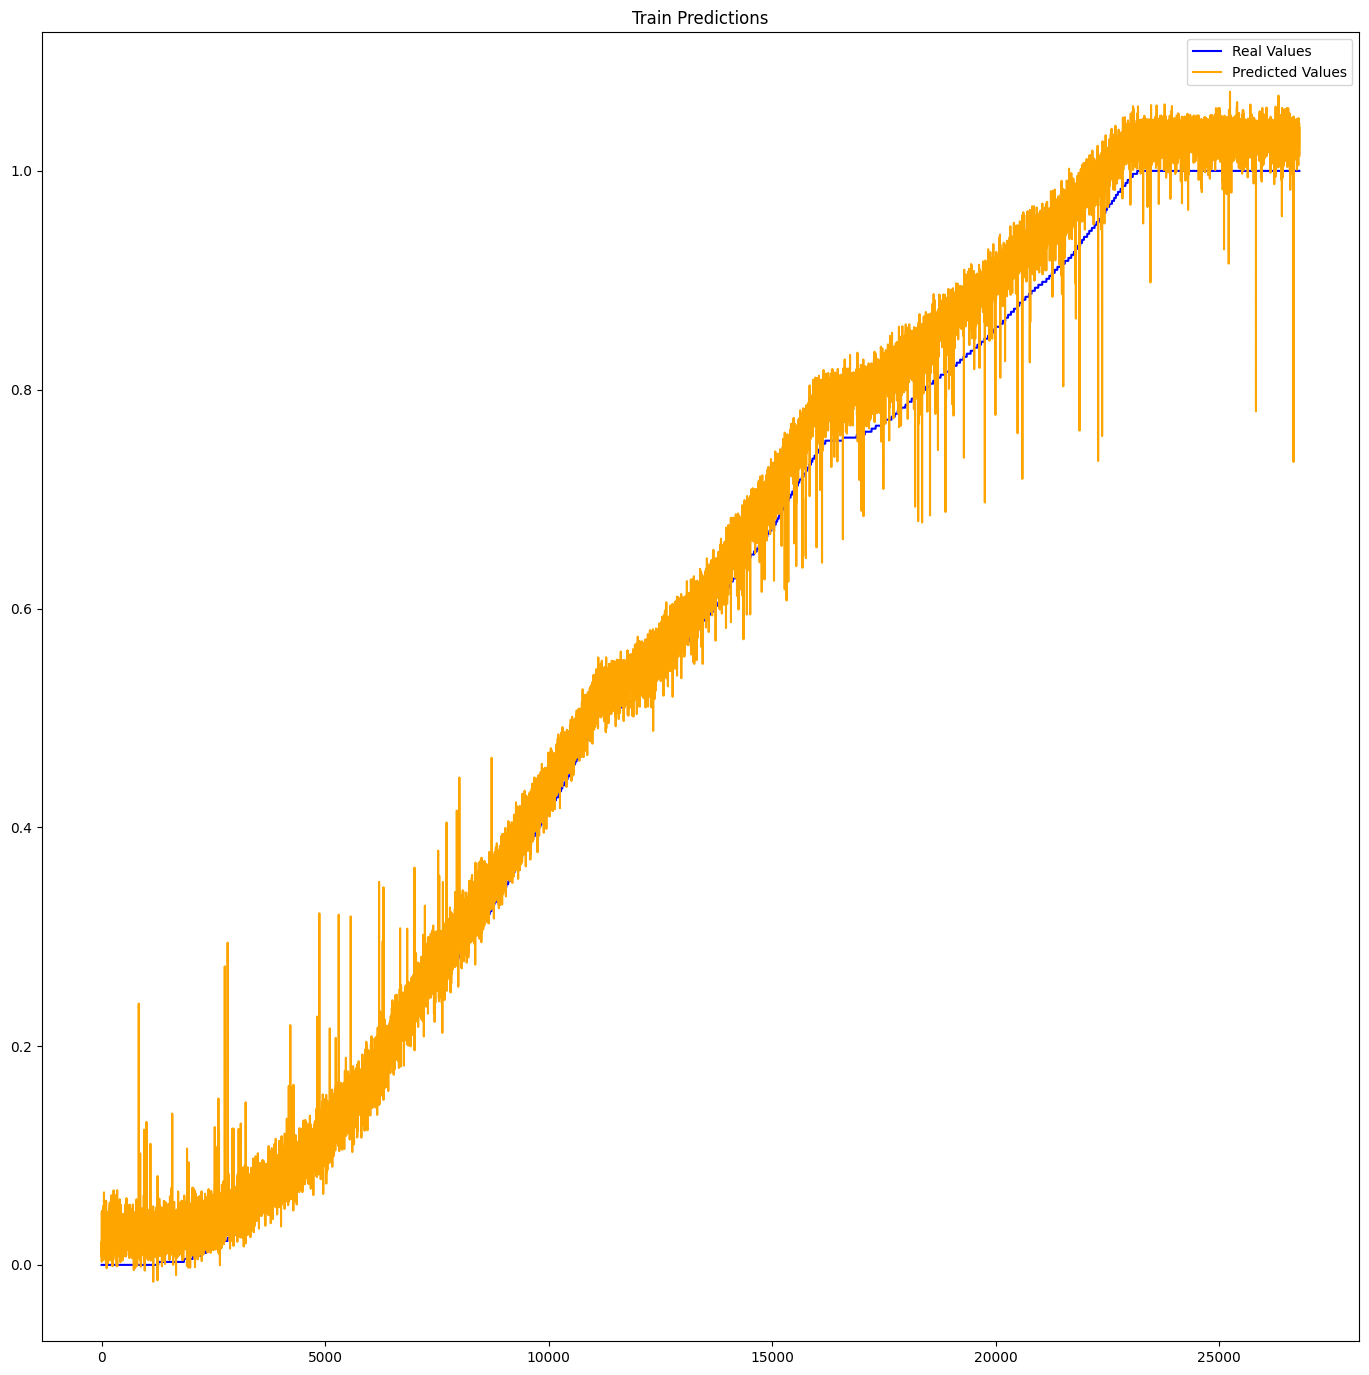

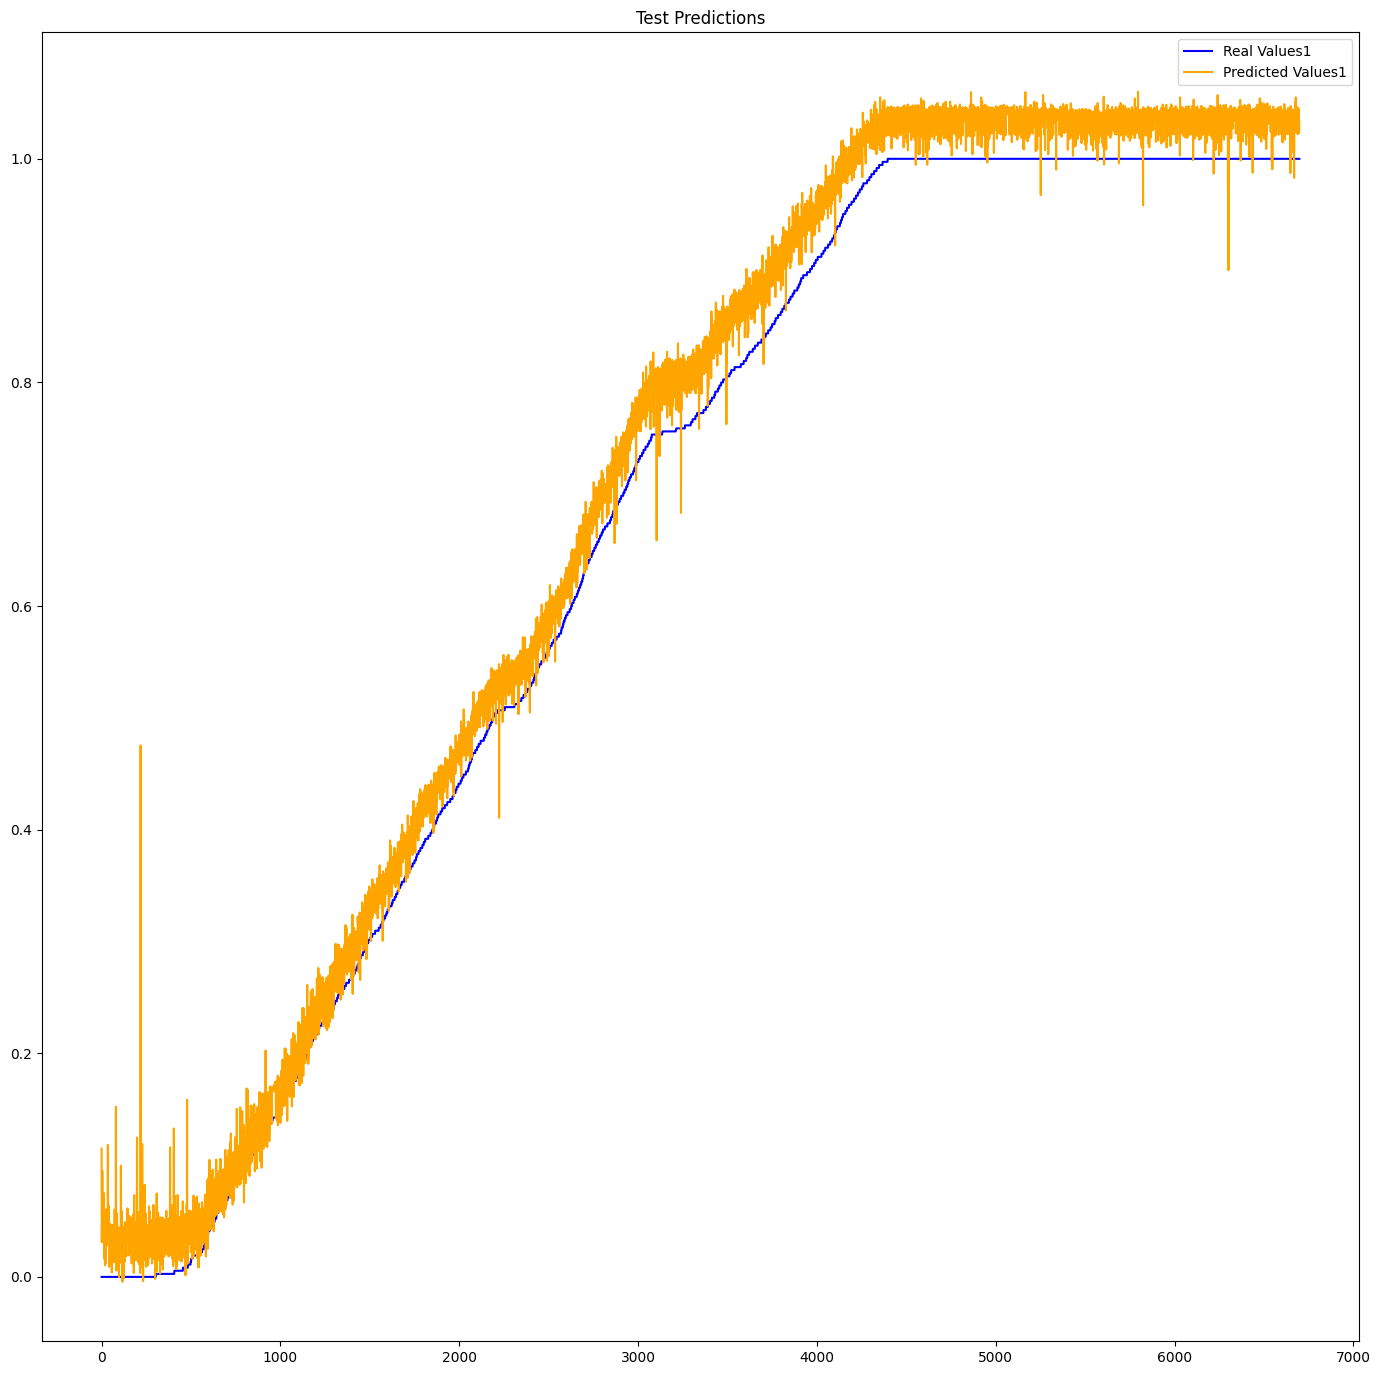


Fold 1:
Train MSE 0.001135197700932622:
Test MSE 0.001412962912581861:
Epoch 1/30
838/838 [==============================] - 7s 8ms/step - loss: 0.2058
Epoch 2/30
838/838 [==============================] - 7s 8ms/step - loss: 0.1180
Epoch 3/30
838/838 [==============================] - 6s 7ms/step - loss: 0.0501
Epoch 4/30
838/838 [==============================] - 6s 8ms/step - loss: 0.0088
Epoch 5/30
838/838 [==============================] - 7s 8ms/step - loss: 0.0072
Epoch 6/30
838/838 [==============================] - 13s 15ms/step - loss: 0.0064
Epoch 7/30
838/838 [==============================] - 12s 15ms/step - loss: 0.0049
Epoch 8/30
838/838 [==============================] - 7s 8ms/step - loss: 0.0047
Epoch 9/30
838/838 [==============================] - 12s 15ms/step - loss: 0.0044
Epoch 10/30
838/838 [==============================] - 14s 17ms/step - loss: 0.0045
Epoch 11/30
838/838 [==============================] - 15s 18ms/step - loss: 0.0037
Epoch 12/30
838/838 [====

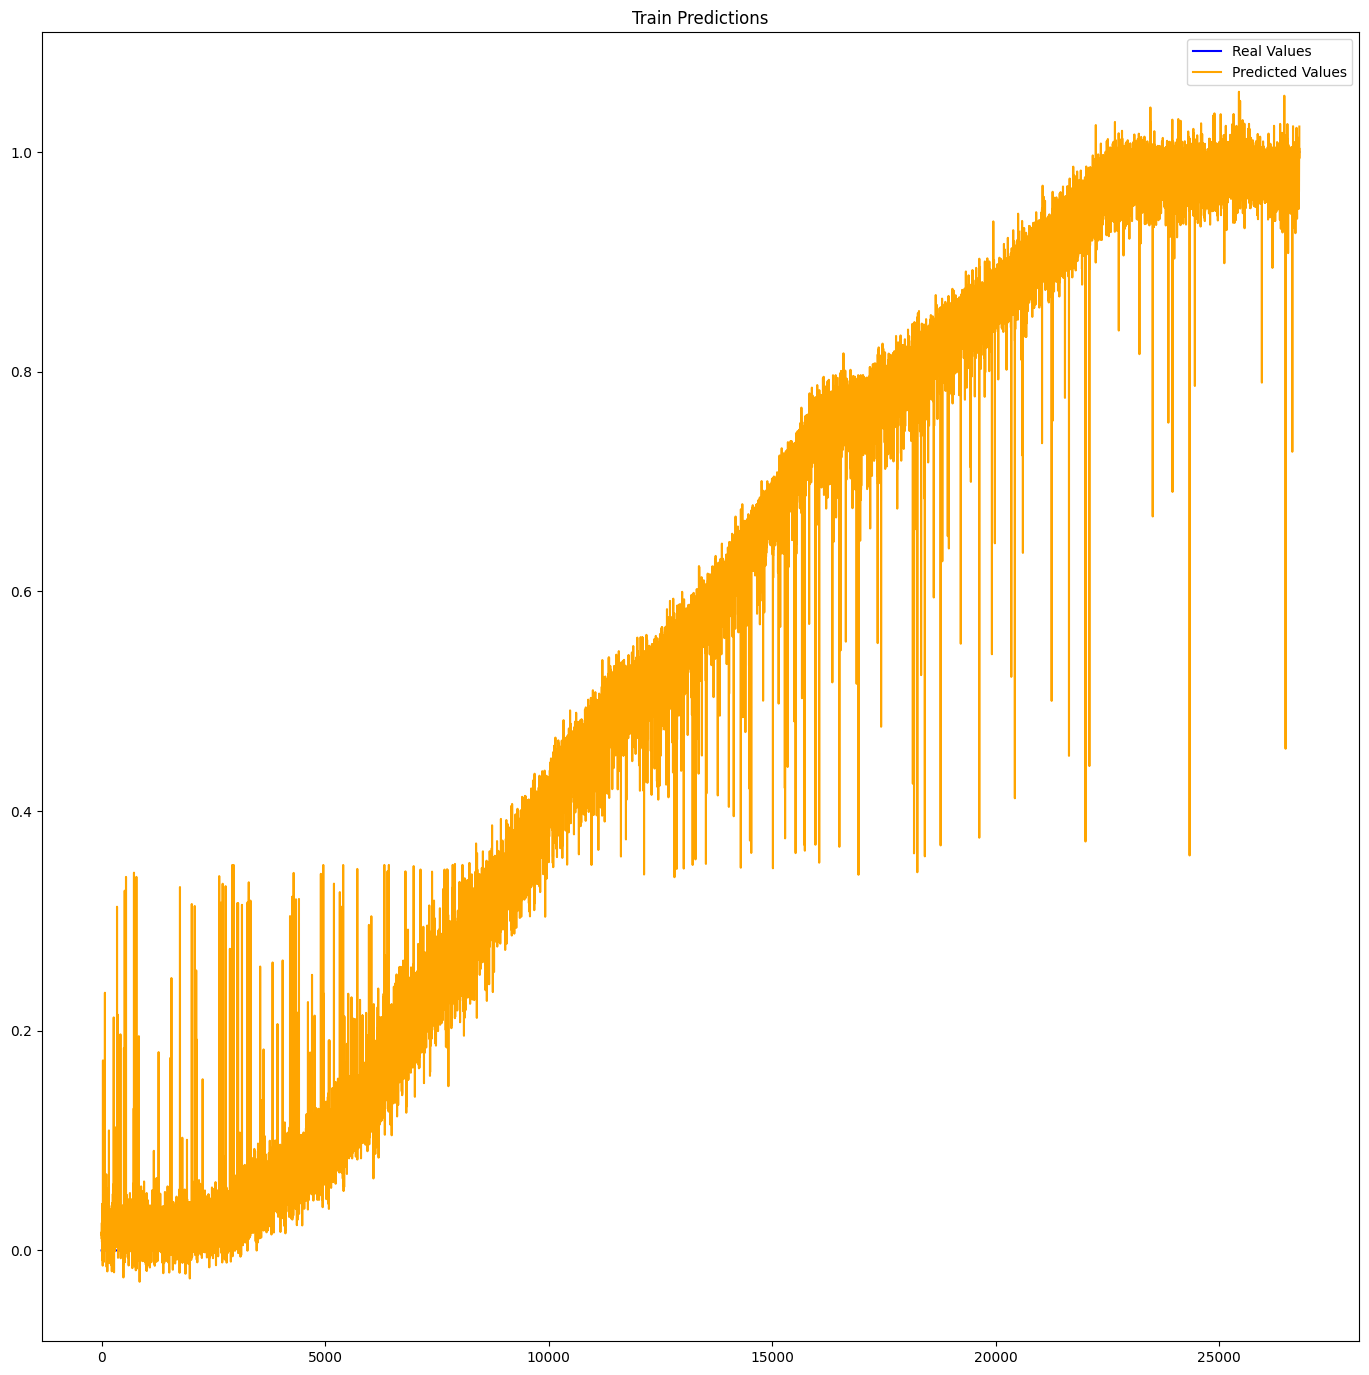

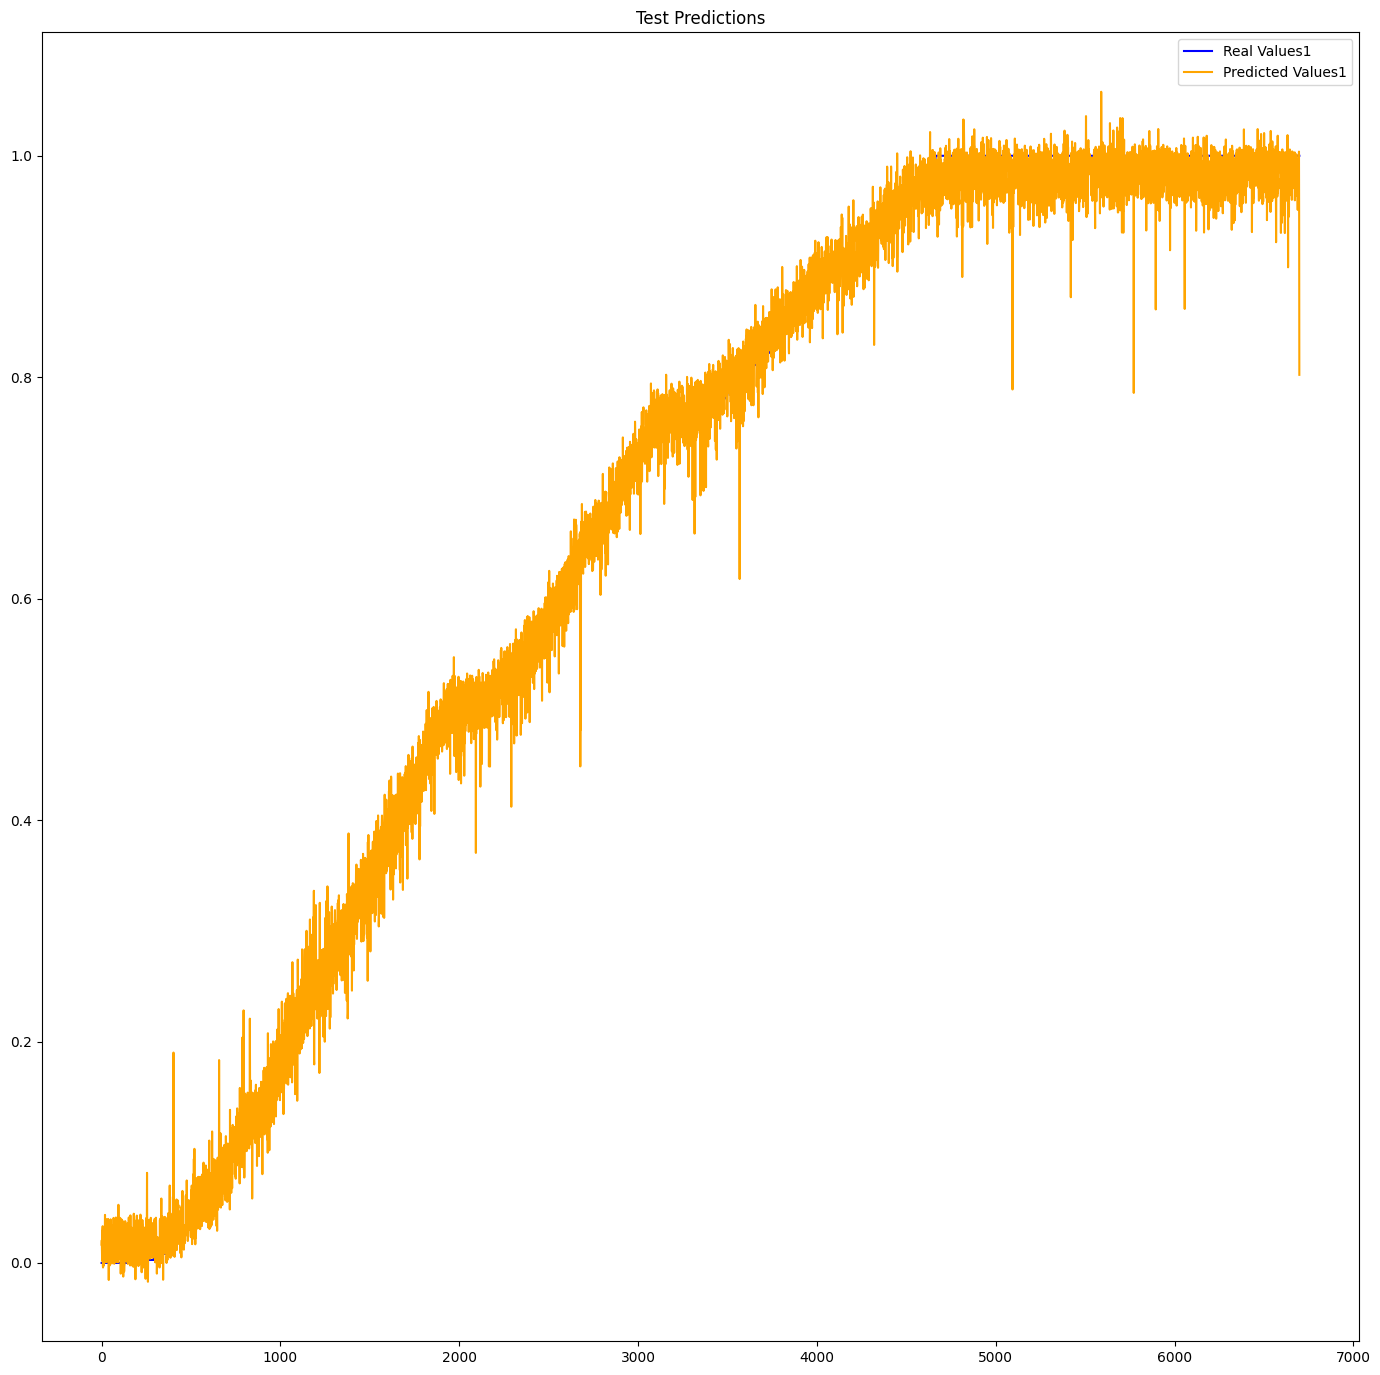


Fold 2:
Train MSE 0.0009392917854711413:
Test MSE 0.0005924122524447739:
Epoch 1/30
838/838 [==============================] - 7s 8ms/step - loss: 0.2189
Epoch 2/30
838/838 [==============================] - 12s 14ms/step - loss: 0.1172
Epoch 3/30
838/838 [==============================] - 14s 16ms/step - loss: 0.0515
Epoch 4/30
838/838 [==============================] - 10s 12ms/step - loss: 0.0064
Epoch 5/30
838/838 [==============================] - 8s 10ms/step - loss: 0.0031
Epoch 6/30
838/838 [==============================] - 8s 10ms/step - loss: 0.0112
Epoch 7/30
838/838 [==============================] - 8s 9ms/step - loss: 0.0048
Epoch 8/30
838/838 [==============================] - 9s 10ms/step - loss: 0.0034
Epoch 9/30
838/838 [==============================] - 15s 18ms/step - loss: 0.0028
Epoch 10/30
838/838 [==============================] - 19s 23ms/step - loss: 0.0037
Epoch 11/30
838/838 [==============================] - 19s 22ms/step - loss: 0.0020
Epoch 12/30
838/83

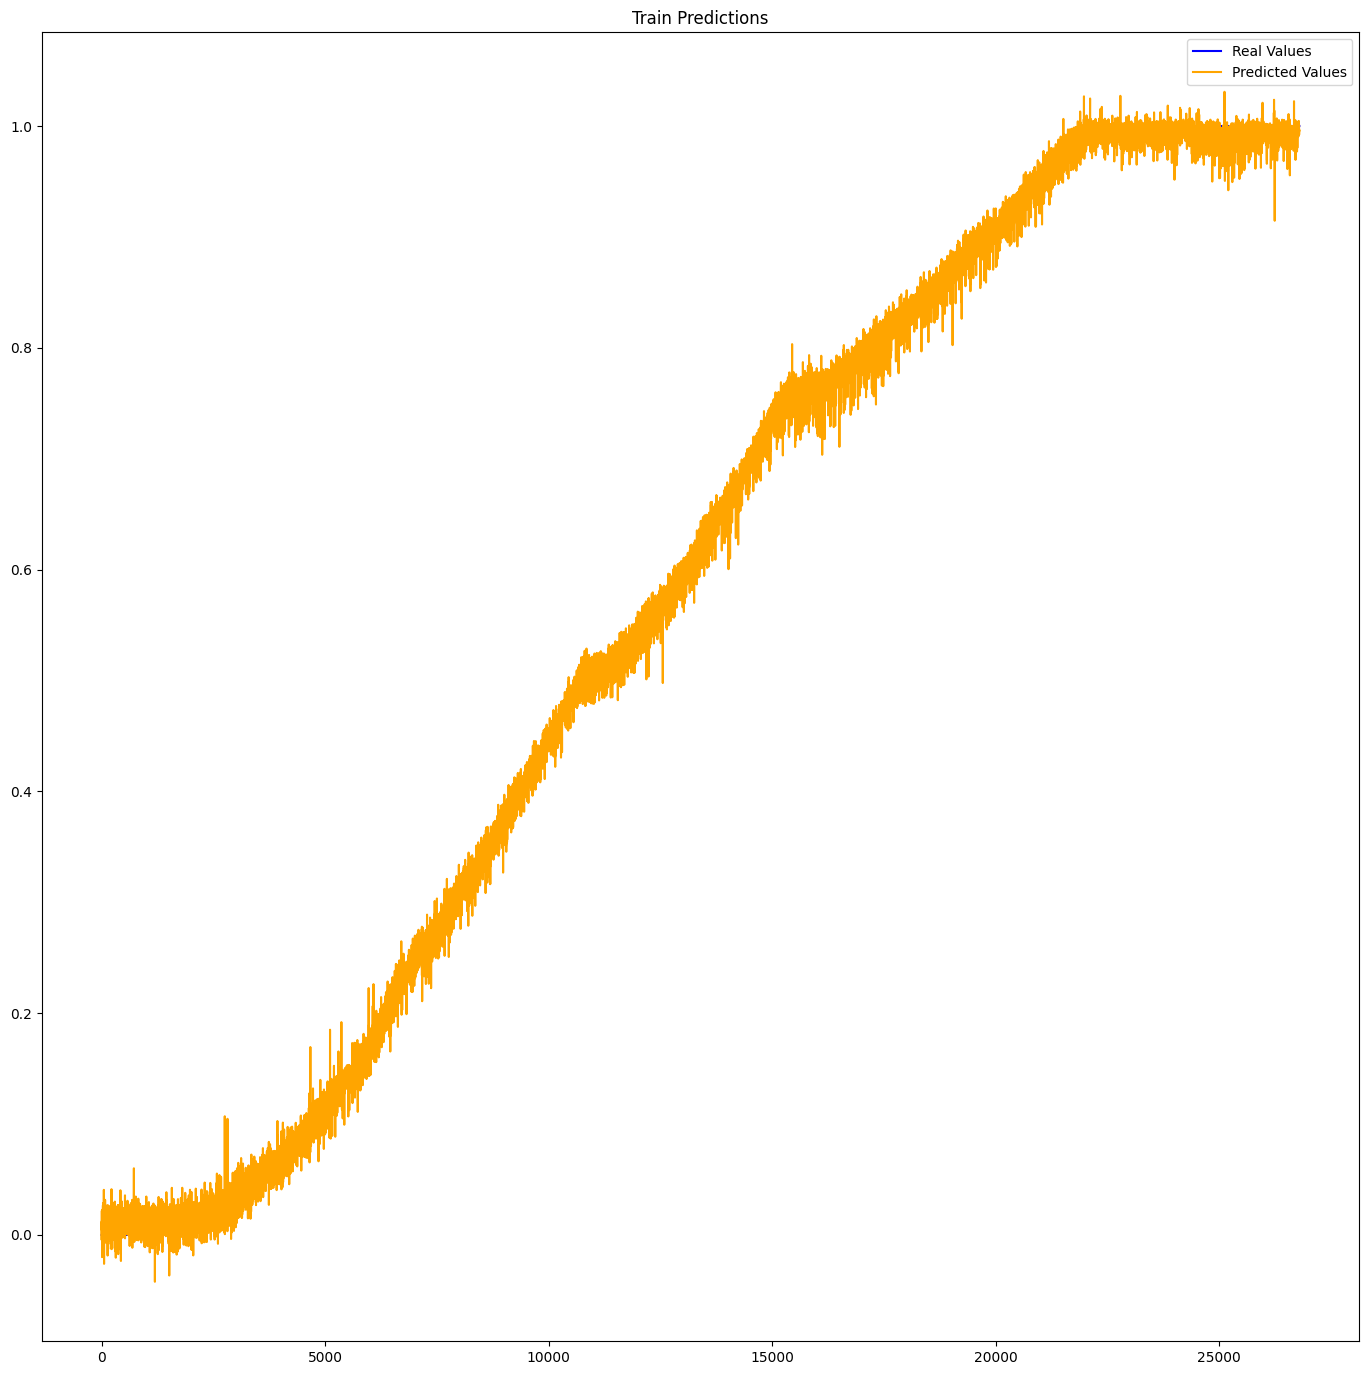

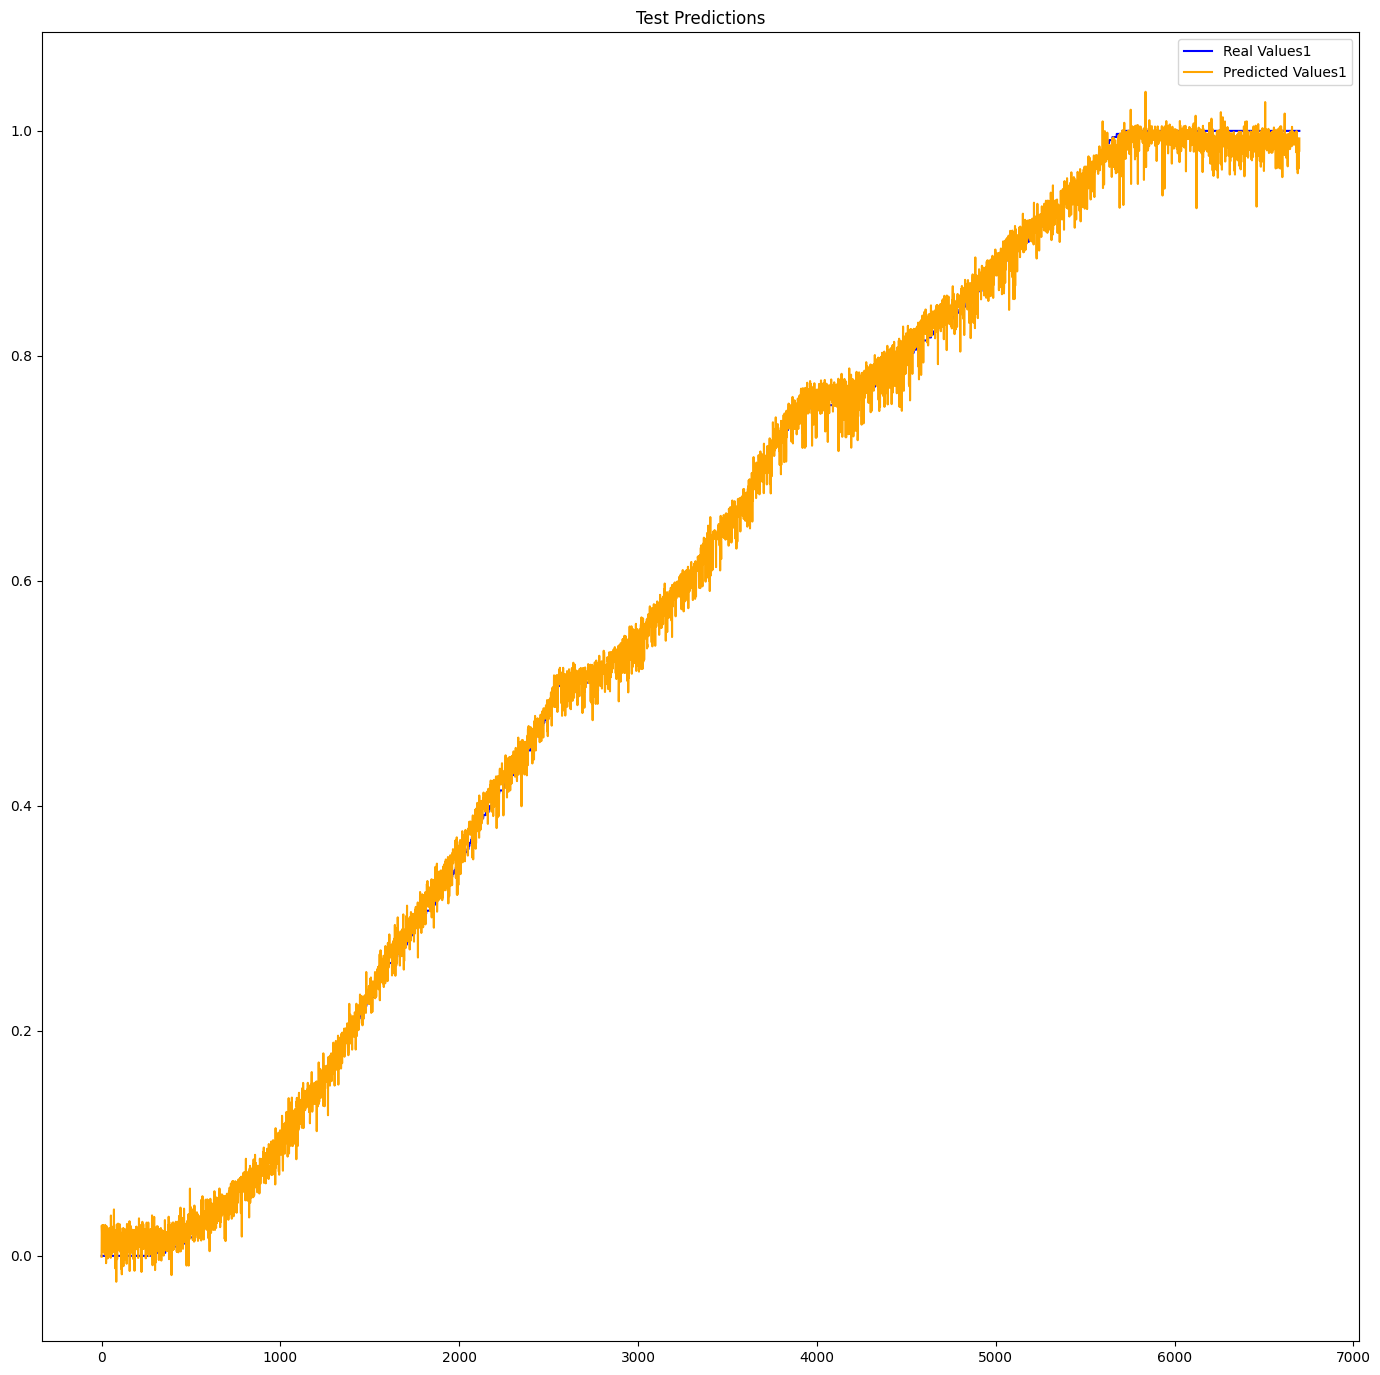


Fold 3:
Train MSE 0.00012075934500899166:
Test MSE 0.00015159734175540507:
Epoch 1/30
838/838 [==============================] - 21s 24ms/step - loss: 0.1969
Epoch 2/30
838/838 [==============================] - 17s 20ms/step - loss: 0.1153
Epoch 3/30
838/838 [==============================] - 19s 22ms/step - loss: 0.0521
Epoch 4/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0086
Epoch 5/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0047
Epoch 6/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0039
Epoch 7/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0036
Epoch 8/30
838/838 [==============================] - 20s 24ms/step - loss: 0.0041
Epoch 9/30
838/838 [==============================] - 18s 22ms/step - loss: 0.0026
Epoch 10/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0084
Epoch 11/30
838/838 [==============================] - 19s 22ms/step - loss: 0.0020
Epoch 12/

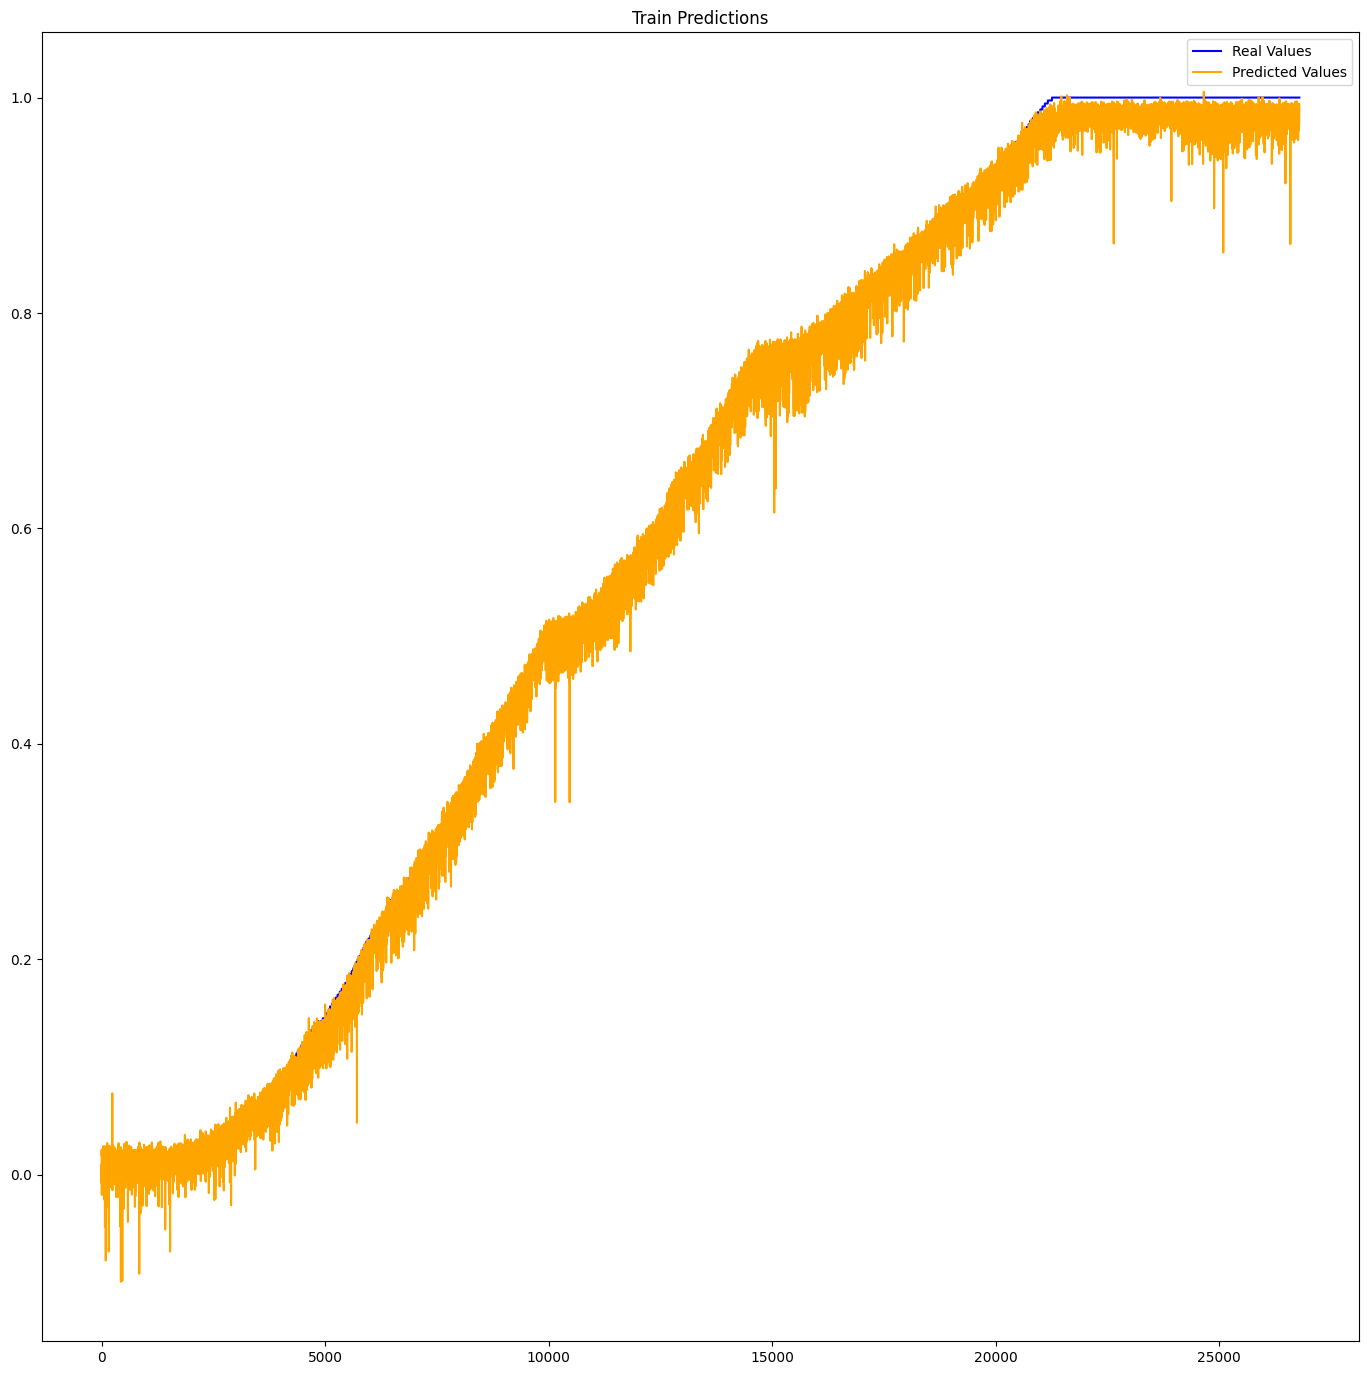

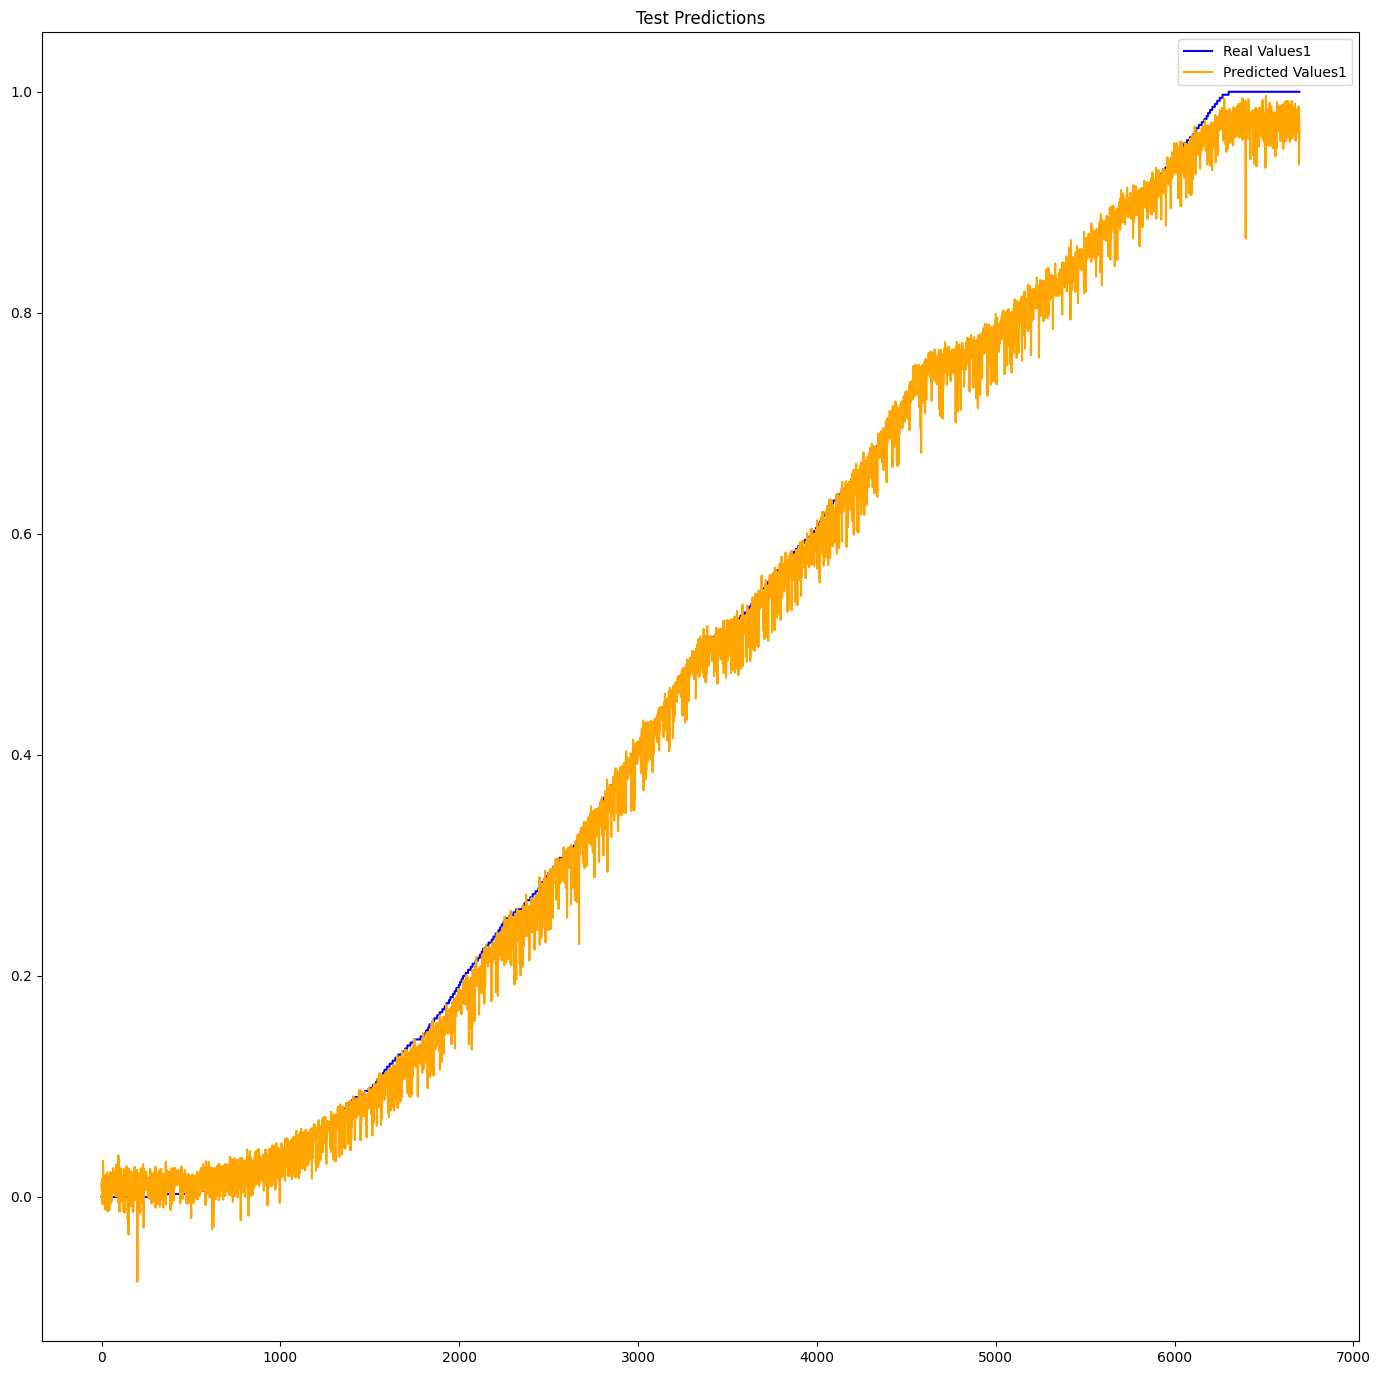


Fold 4:
Train MSE 0.00023368216352537274:
Test MSE 0.0002763844095170498:
Epoch 1/30
838/838 [==============================] - 18s 21ms/step - loss: 0.2253
Epoch 2/30
838/838 [==============================] - 17s 20ms/step - loss: 0.1209
Epoch 3/30
838/838 [==============================] - 20s 24ms/step - loss: 0.0835
Epoch 4/30
838/838 [==============================] - 19s 23ms/step - loss: 0.0089
Epoch 5/30
838/838 [==============================] - 20s 24ms/step - loss: 0.0059
Epoch 6/30
838/838 [==============================] - 21s 25ms/step - loss: 0.0055
Epoch 7/30
838/838 [==============================] - 19s 23ms/step - loss: 0.0093
Epoch 8/30
838/838 [==============================] - 18s 21ms/step - loss: 0.0083
Epoch 9/30
838/838 [==============================] - 16s 19ms/step - loss: 0.0048
Epoch 10/30
838/838 [==============================] - 12s 15ms/step - loss: 0.0042
Epoch 11/30
838/838 [==============================] - 12s 14ms/step - loss: 0.0035
Epoch 12/3

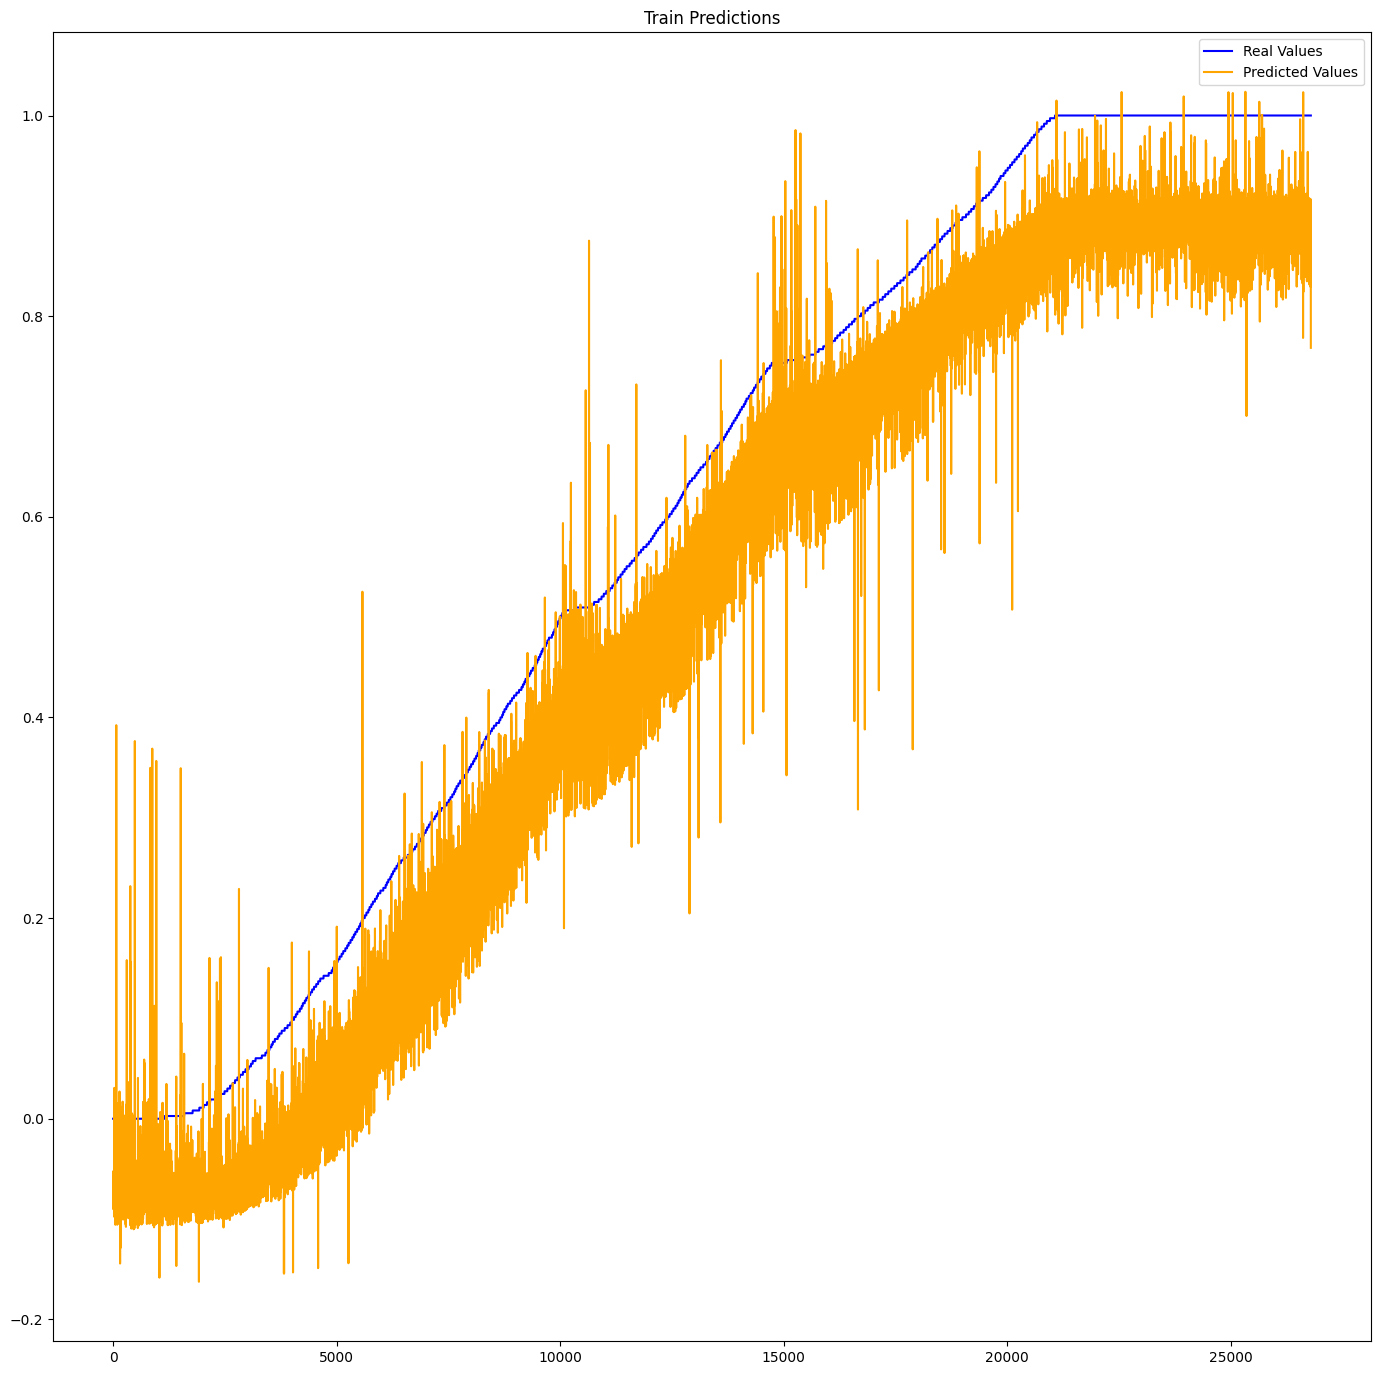

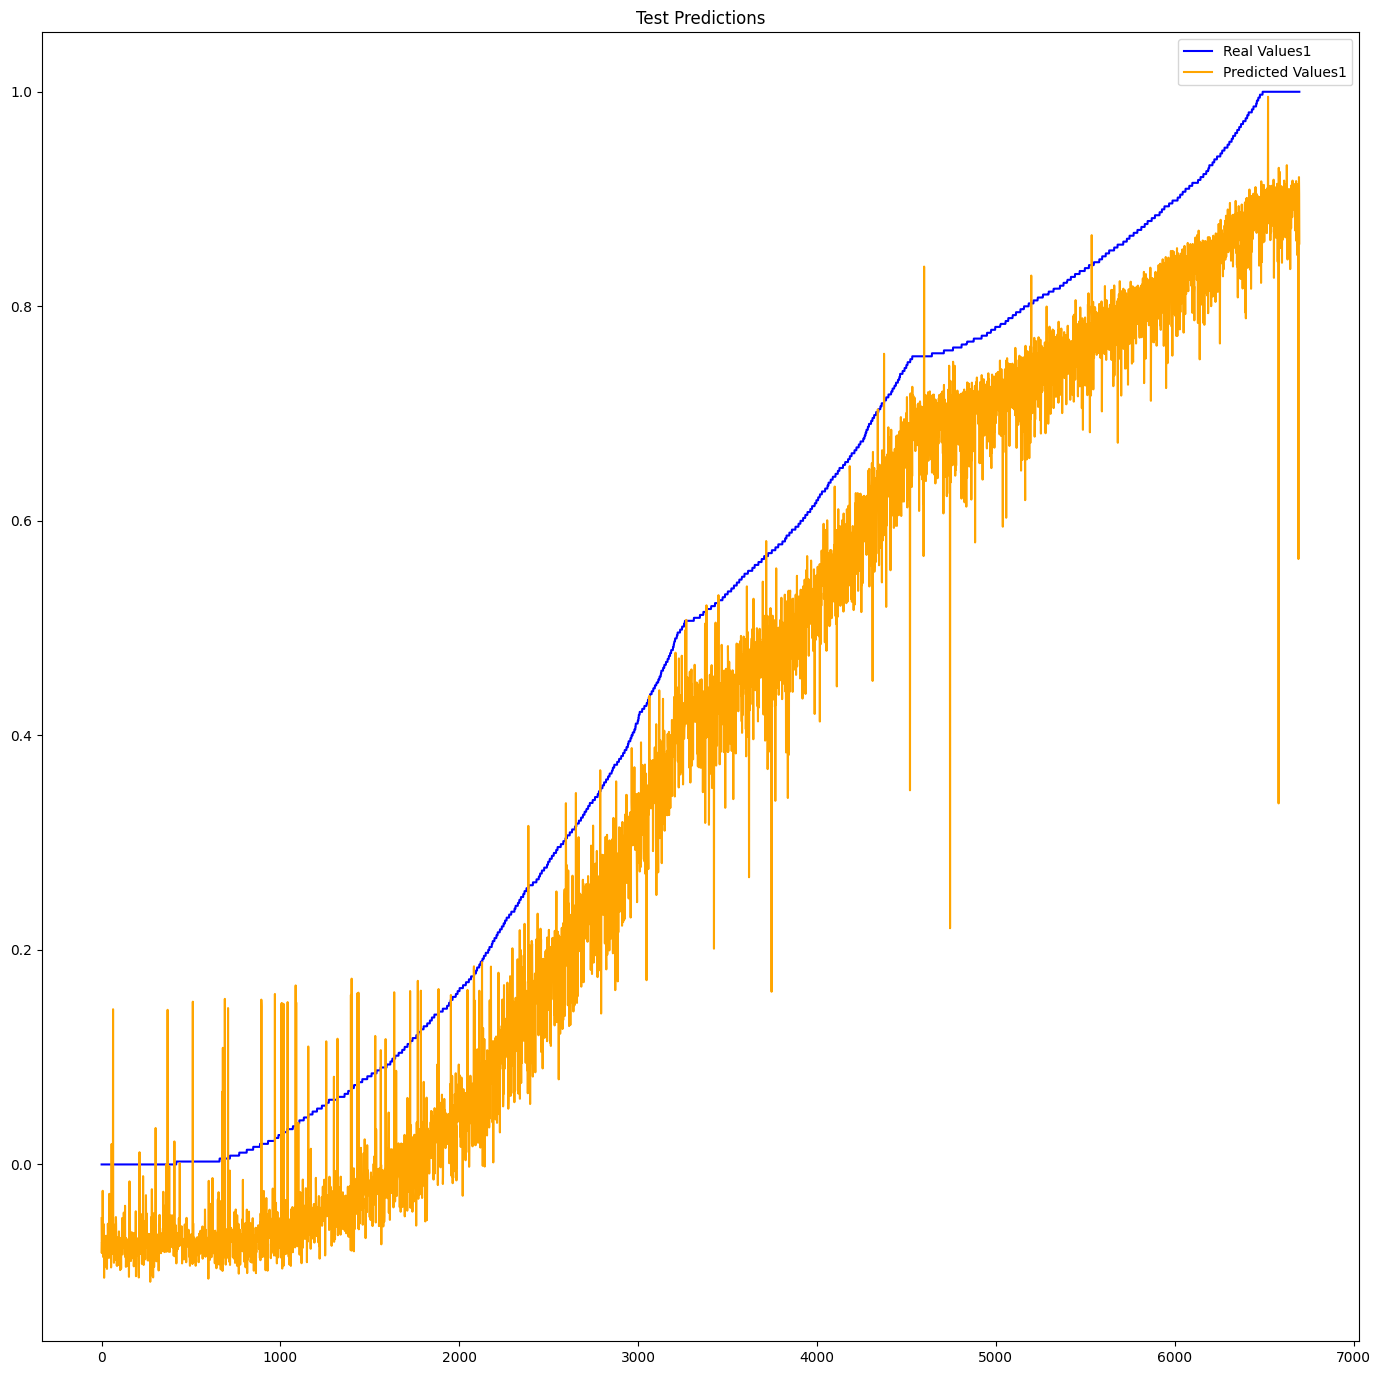


Fold 5:
Train MSE 0.011858870275318623:
Test MSE 0.008773842826485634:

Train MSE:
Mean:  0.00285756025405135
Standard Deviation:  0.004517625133420848

Test MSE:
Mean:  0.002241439948556945
Standard Deviation:  0.0032956589415159003


In [22]:
from sklearn.model_selection import KFold

# Parameters
k = 5

# Initialization
kf = KFold(n_splits=k)

train_scores = []
test_scores = []

results = []
  
i = 0
for train_itr, test_itr in kf.split(X):
    X_train, X_test = X.iloc[train_itr], X.iloc[test_itr]
    Y_train, Y_test = Y.iloc[train_itr], Y.iloc[test_itr]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='sigmoid', input_shape=(X_train.shape[1], )),
        tf.keras.layers.Dense(512, activation='sigmoid'),
        tf.keras.layers.Dense(1024, activation='sigmoid'),
        tf.keras.layers.Dense(1024, activation='sigmoid'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    results.append(model.fit(X_train, Y_train, epochs=no_epochs, verbose=1))
    
    Y_train_Prediction = model.predict(X_train)
    Y_test_Prediction = model.predict(X_test)

    drawGraphs(Y_train, Y_train_Prediction, Y_test, Y_test_Prediction)

    train_score = model.evaluate(X_train, Y_train, verbose=0)
    test_score = model.evaluate(X_test, Y_test, verbose=0)

    train_scores.append(train_score)
    test_scores.append(test_score)

    i += 1
    print(f"\nFold {i}:")
    print(f"Train MSE {train_score}:")
    print(f"Test MSE {test_score}:")


print(f"\nTrain MSE:")
print("Mean: ", np.mean(train_scores))
print("Standard Deviation: ", np.std(train_scores))

print(f"\nTest MSE:")
print("Mean: ", np.mean(test_scores))
print("Standard Deviation: ", np.std(test_scores))
    
    
